![Logo](https://github.com/Fortuz/rl_education/blob/main/assets/logo.png?raw=1)

Made by **Domonkos Nagy**

[<img src="https://colab.research.google.com/assets/colab-badge.svg">](https://colab.research.google.com/github/Fortuz/rl_education/blob/main/8.%20Function%20Approximation/neural_networks.ipynb)

# Neural Networks in Pytorch
<img src="https://github.com/Fortuz/rl_education/blob/main/8.%20Function%20Approximation/assets/pytorch.png?raw=1" width="200">

This notebook walks through the process of creating, training and evaluating a convolutional neural network for handwritten digit classification using PyTorch.

- Documentation for PyTorch: https://pytorch.org/docs/stable/index.html

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt

## The network architecture

To create a neural network, we have to inherit from the `torch.nn.Module` class, and define forward pass in the `forward` method.
This network has two convolutional layers and one max-pooling layer, followed by two fully connected layers. The final layer has
10 nodes, each corresponding to one of the 10 digits we want to classify. A visualization of this architecture can be seen below.

The network also has two dropout layers, one after the max-pooling layer and one after the first fully connected layer.
Dropout layers randomly zero out some of their inputs with probability $p$ (supplied as the initialization parameter), but they
are only active during training, and have no effect during inference. Dropout layers are commonly used for regularization, to
prevent overfitting.

Except for the final layer, the activation function for all layers is the *ReLU* (**Re**ctified **L**inear **U**nit) function,
defined simply as $\text{ReLU}(x) := \max(0, x)$. The activation for the final layer is the *LogSoftmax* function, which is
the logarithm of the SoftMax function. The SoftMax function is defined as:

$$\sigma(z)_i := \frac{e^{z_i}}{\sum_{j=1}^K e^{z_j}} \text{ for } i = 1,...,K$$

Notice how it transforms the input vector to a probability distribution: each component of the output is between 0 and 1,
and their sum is exactly 1. SoftMax is commonly used for classification, since it gives us a nice representation of how
probable the network thinks that the input belongs to each of the classes. Taking the logarithm is beneficial for numerical stability.

Also, notice how we only have to define the forward pass: the autograd engine behind PyTorch will manage the backward
pass for any loss function.

- This video by Andrej Karpathy is a great introduction to how backpropagation and PyTorch's autograd engine works: https://www.youtube.com/watch?v=VMj-3S1tku0

<img src="https://github.com/Fortuz/rl_education/blob/main/8.%20Function%20Approximation/assets/nn.svg?raw=1" width="1000">

*The network architecture*

In [2]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Convolutional layers
        self.conv1 = nn.Conv2d(1, 32, 3)
        self.conv2 = nn.Conv2d(32, 64, 3)
        # Droput layers
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        # Fully connected layers
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        # Convolution 1
        x = self.conv1(x)
        x = F.relu(x)
        # Convolution 2
        x = self.conv2(x)
        x = F.relu(x)
        # Pooling, dropout, flattening
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        # Fully connected 1 + dropout
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        # Fully connected 2
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

In [3]:
# Hyperparameters
ALPHA = 0.001  # Learning rate
LOG_INTERVAL = 150  # Batches to wait before logging training status
N_EPOCHS = 5  # Number of iterations over the training set
TRAIN_BATCH_SIZE = 128  # Batch size for training
TEST_BATCH_SIZE = 1000  # Batch size for testing

## Devices in PyTorch

To speed up training, you can transfer computations to specific devices using the `to(device)` function (see below). Before that, we have to specify which device
do we want to use: this block automatically selects the most powerful device based on hardware capabilities.

In [4]:
# Set device
use_cuda = torch.cuda.is_available()
use_mps = torch.backends.mps.is_available()

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

if use_cuda:
    device = torch.device("cuda")
elif use_mps:
    device = torch.device("mps")

print(f'Device: {device}')

# Set train/test args
train_kwargs = {'batch_size': TRAIN_BATCH_SIZE, 'shuffle': True}
test_kwargs = {'batch_size': TEST_BATCH_SIZE, 'shuffle': True}

Device: cuda


## The MNIST dataset

The MNIST dataset contains 70,000 28x28 pixel images of handwritten digits from 0 to 9.
Below we are loading the dataset, and defining two `DataLoader`s, one for the training set, and another for the test set. A PyTorch
`DataLoader` gives us an iterator over a dataset, with the possibility to define batch size, reshuffling, and other useful features.

<img src="https://github.com/Fortuz/rl_education/blob/main/8.%20Function%20Approximation/assets/mnist.png?raw=1" width="600">

*Sample images from MNIST test dataset (source: Wikipedia)*

In [5]:
# Load train and test set
train_set = datasets.MNIST(root='data',
                           train=True,
                           download=True,
                           transform=transforms.ToTensor())
test_set = datasets.MNIST(root='data',
                          train=False,
                          download=True,
                          transform=transforms.ToTensor())

# Create dataloaders
train_loader = torch.utils.data.DataLoader(train_set, **train_kwargs)
test_loader = torch.utils.data.DataLoader(test_set, **test_kwargs)

In [6]:
# Print dataset info
print('-- TRAIN SET --')
print(train_set)
print(f'Data shape: {train_set.data.shape}')
print(f'Targets shape: {train_set.targets.shape}')
print()
print('-- TEST SET --')
print(test_set)
print(f'Data shape: {test_set.data.shape}')
print(f'Targets shape: {test_set.targets.shape}')

-- TRAIN SET --
Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()
Data shape: torch.Size([60000, 28, 28])
Targets shape: torch.Size([60000])

-- TEST SET --
Dataset MNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: ToTensor()
Data shape: torch.Size([10000, 28, 28])
Targets shape: torch.Size([10000])


## Training and testing

For each epoch, we train the model on the training set and then evaluate on the test set. Before either training or evaluating, the mode
of the model is set: some layers behave differently in `train` mode than in `eval` mode, for example, the dropout layers are only active
during training.

After setting the mode, the training function loops over the dataset: for each batch, it zeroes out the gradients of the model parameters,
runs a forward pass, calculates the loss, then runs a backward pass, and finally makes an optimization step. Here we are using the Adam
optimizer.

The test function works similarly, but here we don't perform optimization steps, and since gradient calculations are unecessary for testing,
we are using the `no_grad` context manager for improved speed.

In [7]:
# Initialize model
model = Net().to(device)
# Initialize optimizer
optimizer = optim.Adam(model.parameters(), lr=ALPHA)

In [8]:
def train(model, device, train_loader, optimizer, epoch):
    model.train()  # Set model to train mode

    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)  # Transfer data and target to device
        optimizer.zero_grad()  # Reset gradients

        output = model(data)  # Forward pass
        loss = F.nll_loss(output, target)  # Negative log-likelihood loss
        loss.backward()  # Backward pass
        optimizer.step()  #  Optimization
        if batch_idx % LOG_INTERVAL == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch+1, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

In [9]:
def test(model, device, test_loader):
    model.eval()  # Set model to evaluation mode
    test_loss = 0
    correct = 0

    # Disable gradient calculation
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)  # Transfer data and target to device
            output = model(data)  # Forward pass
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # Sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # Get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()  # Add up correct predictions

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [10]:
for epoch in range(N_EPOCHS):
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

model_scripted = torch.jit.script(model)  # Export to TorchScript
model_scripted.save('model_scripted.pt')  # Save

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.299655
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.144578
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.240260
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.122712

Test set: Average loss: 0.0551, Accuracy: 9825/10000 (98%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.164314
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.067375
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.110783
Train Epoch: 2 [57600/60000 (96%)]	Loss: 0.117167

Test set: Average loss: 0.0400, Accuracy: 9862/10000 (99%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.072603
Train Epoch: 3 [19200/60000 (32%)]	Loss: 0.052216
Train Epoch: 3 [38400/60000 (64%)]	Loss: 0.047382
Train Epoch: 3 [57600/60000 (96%)]	Loss: 0.096144

Test set: Average loss: 0.0326, Accuracy: 9883/10000 (99%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.104605
Train Epoch: 4 [19200/60000 (32%)]	Loss: 0.073846
Train Epoch: 4 [38400/60000 (64%)]	Loss: 0.048271
Train Epoch: 4 [57600/60000 (96%)]	Loss: 0.041731

Test set: Average loss: 0.0332, Accu

## Results

The following block shows a few random examples from the test set along with the predictions made by the model.

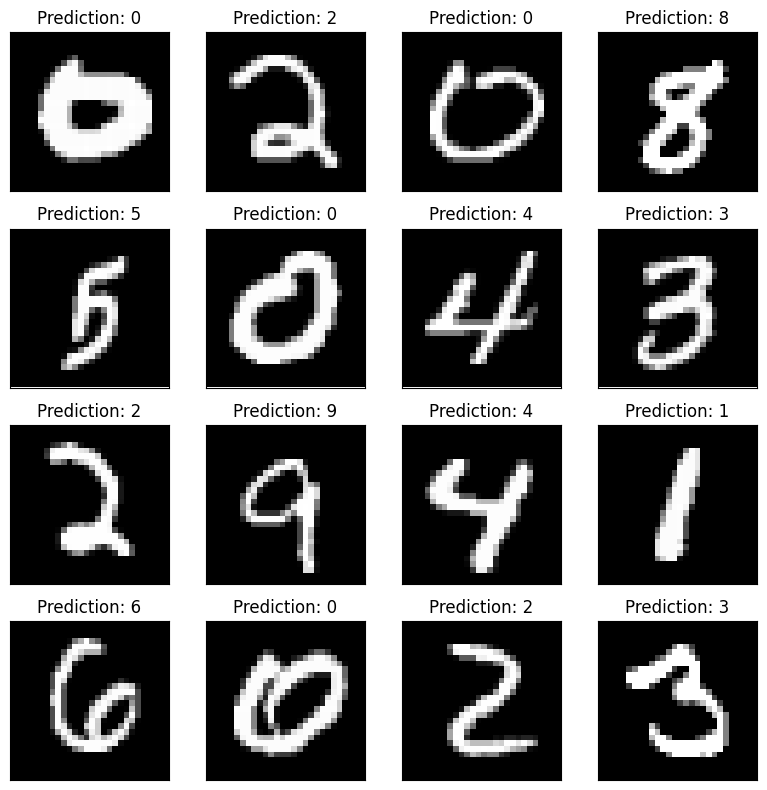

In [11]:
model = torch.jit.load('model_scripted.pt')  # Load model
model.eval()

# Plot examples
n_rows = 4
n_cols = 4

fig = plt.figure(figsize=(n_cols * 2, n_rows * 2))
for i in range(n_rows * n_cols):
    ax = fig.add_subplot(n_rows, n_cols, i + 1)
    ax.tick_params(left=False, right=False, labelleft=False,
                    labelbottom=False, bottom=False)
    data, target = test_set[np.random.randint(0, test_set.data.shape[0])]
    data = data.unsqueeze(0).to(device)
    output = model(data)
    prediction = output.argmax(dim=1, keepdim=True).item()
    image = data.squeeze(0).squeeze(0).cpu().numpy()

    ax.imshow(image, cmap='gray')
    ax.set_title(f'Prediction: {prediction}')
plt.tight_layout()
plt.show()